In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wandb
import statistics
import io
import PIL
from PIL import Image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2

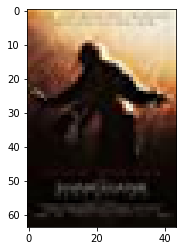

In [26]:
class IMDB(Dataset):
    def __init__(self, URL: str = "https://www.imdb.com/chart/top-english-movies", IMG_SIZE: tuple = (44,64)):
        self.URL = URL
        self.IMG_SIZE = IMG_SIZE
        self.transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        movie_list = soup.find(class_='lister-list')
        movie_elems = movie_list.find_all('tr')
    
        movTitle = []
        movYear = []
        movRating = []
        movPoster = []

        for elm in movie_elems:
            title = elm.find('td', 'titleColumn').a['title']
            movTitle.append(title)
            year = int(elm.find('td', 'titleColumn').span.string[1:-1])
            movYear.append(year)
            rating = float(elm.find('td', 'ratingColumn imdbRating').strong.string)
            movRating.append(rating)
            posterURL = elm.find('td', 'posterColumn').a.img['src']
            data = requests.get(posterURL).content
            img = Image.open(io.BytesIO(data)).resize(IMG_SIZE)
            array = np.array(img, dtype='uint8')
            movPoster.append(array)

        imdb = {'Movie Title':movTitle, 'Year Published':movYear, 'IMDb Rating':movRating, 'Movie Poster': movPoster}
        self.df = pd.DataFrame(imdb)


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, index:int) -> np.ndarray:
        image = self.transform(self.df['Movie Poster'][index]).reshape(3, *self.IMG_SIZE) #.astype('float32')
        return image
    
    def displayImage(self, index:int):
        image = self.df['Movie Poster'][index]
        plt.imshow(image)


imdbDataset = IMDB()
imdbDataset.displayImage(0)

In [27]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.001

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       

        #Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 3, 2, stride=2)
        self.out = nn.AdaptiveMaxPool3d((3, 44, 64))


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.sigmoid(self.out(x))

        return x

#Instantiate the model
model = ConvAutoencoder()

#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = config.learning_rate)

Error: You must call wandb.init() before wandb.config.learning_rate

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

In [5]:
run = wandb.init(project='MovieWeb', entity='cmerrill')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [30]:
train_loader = DataLoader(
    imdbDataset,
    batch_size=10,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

In [7]:
wandb.watch(model)

In [33]:
for i in train_loader:
    print(i)

  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9686, 0.9725, 0.9725]]],


        [[[0.7098, 0.7176, 0.8353,  ..., 0.8431, 0.8706, 0.8588],
          [0.8627, 0.8980, 0.9373,  ..., 0.6039, 0.5569, 0.4353],
          [0.4745, 0.4902, 0.7137,  ..., 0.8627, 0.9255, 0.7765],
          ...,
          [0.3098, 0.4471, 0.3961,  ..., 0.1294, 0.1137, 0.1098],
          [0.1059, 0.0941, 0.0824,  ..., 0.1882, 0.0510, 0.0235],
          [0.0941, 0.0941, 0.0784,  ..., 0.0118, 0.0118, 0.0157]],

         [[0.7412, 0.7490, 0.8667,  ..., 0.9176, 0.9373, 0.9020],
          [0.8902, 0.9059, 0.9451,  ..., 0.6784, 0.6275, 0.5020],
          [0.5294, 0.5529, 0.7804,  ..., 0.9255, 0.9843, 0.8549],
          ...,
          [0.2667, 0.4000, 0.3490,  ..., 0.0706, 0.0627, 0.0588],
          [0.0706, 0.0745, 0.0745,  ..., 0.1961, 0.0549, 0.0235],
          [0.0863, 0.0863, 0.0706,  ..., 0.0078, 0.0078, 0.0118]],

         [[0.8157, 0.8235, 0.9412,  ..., 0.9569, 0.9686, 0.9373],
      

In [8]:
#Epochs
n_epochs = 1500

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images in train_loader:
        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

    wandb.log({"loss": train_loss})

ning Loss: 4.954680
Epoch: 113 	Training Loss: 4.954677
Epoch: 114 	Training Loss: 4.954675
Epoch: 115 	Training Loss: 4.954673
Epoch: 116 	Training Loss: 4.954671
Epoch: 117 	Training Loss: 4.954669
Epoch: 118 	Training Loss: 4.954667
Epoch: 119 	Training Loss: 4.954665
Epoch: 120 	Training Loss: 4.954663
Epoch: 121 	Training Loss: 4.954661
Epoch: 122 	Training Loss: 4.954658
Epoch: 123 	Training Loss: 4.954655
Epoch: 124 	Training Loss: 4.954652
Epoch: 125 	Training Loss: 4.954648
Epoch: 126 	Training Loss: 4.954645
Epoch: 127 	Training Loss: 4.954642
Epoch: 128 	Training Loss: 4.954639
Epoch: 129 	Training Loss: 4.954636
Epoch: 130 	Training Loss: 4.954633
Epoch: 131 	Training Loss: 4.954631
Epoch: 132 	Training Loss: 4.954628
Epoch: 133 	Training Loss: 4.954626
Epoch: 134 	Training Loss: 4.954623
Epoch: 135 	Training Loss: 4.954621
Epoch: 136 	Training Loss: 4.954618
Epoch: 137 	Training Loss: 4.954615
Epoch: 138 	Training Loss: 4.954612
Epoch: 139 	Training Loss: 4.954610
Epoch: 1

KeyboardInterrupt: 

In [10]:
run.finish()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


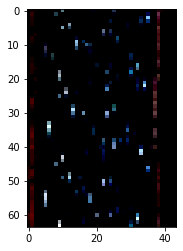

In [25]:
plt.imshow(images[0].T)

Original Images


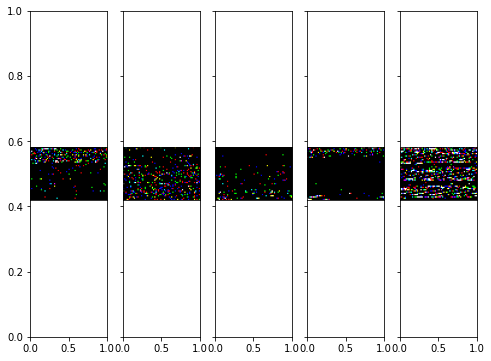

Reconstructed Images


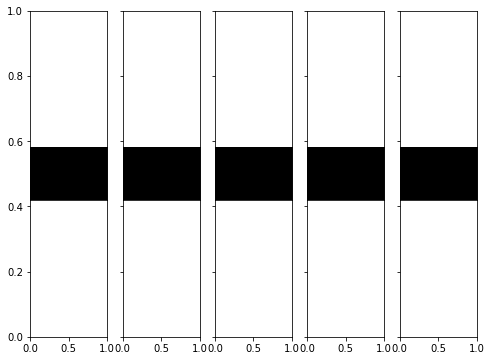

In [11]:
#Batch of test images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.cuda()

#Sample outputs
output = model(images)
images = images.cpu().data.numpy()
output = output.view(train_loader.batch_size, 3, *imdbDataset.IMG_SIZE)
output = output.cpu().data.numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(8,6))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].reshape(*imdbDataset.IMG_SIZE, 3).astype('uint8'))
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(8,6))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx].reshape(*imdbDataset.IMG_SIZE, 3).astype('uint8'))
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

IMDb_df.plot.scatter("Year Published", "IMDb Rating", ax=ax1)

lr = LinearRegression().fit(np.array(IMDb_df['Year Published']).reshape(-1,1), np.array(IMDb_df['IMDb Rating']).reshape(-1,1))
IMDb_df.plot.scatter(x='Year Published', y='IMDb Rating', ax=ax2)
ax2.plot(np.array(IMDb_df['Year Published']) , lr.predict(np.array(IMDb_df['Year Published']).reshape(-1,1)), color = 'r')
plt.subplots_adjust(right=1.656)

plt.show()

In [ ]:
# #def getMetaCritic(URL):

# movie_list = soup.find(class_='clamp-list')

# movie_elems = movie_list.find_all('tr')

# page = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

# webpage = urlopen(page).read()

# soup = BeautifulSoup(webpage, "html.parser")

 

# for elm in movie_elems:
#   try:
#     title = elm.find('td', 'clamp-summary-wrap').find('a', "title").h3.string
#     movTitle.append(title)
#     year = int(elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-details').span.string[-4:])
#     movYear.append(year)
#     rating = float(elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-score-wrap').a.div.string)
#     movRating.append(rating)
#   except AttributeError:
#     continue

# meta = {'Movie Title':movTitle, 'Year Published':movYear, 'Metacritic Rating':movRating}
# pd.DataFrame(meta) #Add Return when converted into Function


# elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-score-wrap').a.div.string

In [ ]:
x = [1,-2,5] 
y = [1,-2,5]
y_bar = sum(y)/len(y) #8.1
x_bar = sum(x)/len(x) #1973.33

In [ ]:
tot = 0
for x_val,y_val in zip(x,y):
  x_var = (x_val - x_bar)* -1
  y_var = (y_val - y_bar)* -1
  tot += x_var * y_var
tot/len(x)

In [ ]:
np.dot((np.array(x) - np.average(x)),(np.array(y) - np.average(y)))/np.array(x).shape[0]

In [ ]:
a = np.ones((4,7)) + 4

In [ ]:
b = np.ones((3,4)) /2

In [ ]:
np.dot(b, a)

In [ ]:
x = np.array([1, 5, 4, 7])
y = x * 5 + 7

In [ ]:
fig, ax = plt.subplots()
ax.scatter([1, 5, 4, 7], [12, 32, 27, 42])
ax.set_ylabel("y label")
ax.set_xlabel('x label')
plt.show()

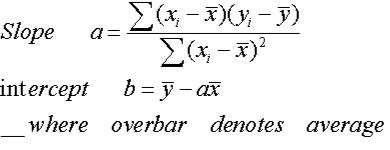

In [ ]:
a_numer = np.dot(x - np.average(x), y - np.average(y))
a_denom = np.dot(x - np.average(x), x - np.average(x))

In [ ]:
a = a_numer/a_denom

In [ ]:
b = np.average(y) - a * np.average(x)

In [ ]:
fig, ax = plt.subplots()
ax.scatter([1, 5, 4, 7], [12, 32, 27, 42])
ax.set_ylabel("y label")
ax.set_xlabel('x label')
plt.plot(x, a*x + b,'g-')
plt.show()

In [ ]:
scaler = StandardScaler()
scaler.fit(x.reshape(-1, 1))
scaler.transform(x.reshape(-1, 1))

In [ ]:
class Perceptron:

    def __init__(self, no_of_inputs, threshold=100, learning_rate=0.01):
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.weights = np.zeros(no_of_inputs + 1)
           
    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        if summation > 0:
          activation = 1
        else:
          activation = 0            
        return activation

    def train(self, training_inputs, labels):
        for _ in range(self.threshold):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.predict(inputs)
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs
                self.weights[0] += self.learning_rate * (label - prediction)

In [ ]:
listy = [1,2,3]
listx = [3,2,1,0]
for x in zip(listx,listy):
  print(x)

In [ ]:
myPerceptron = Perceptron(4)

In [ ]:
[(3,1), (2,2), (1,3)]

In [ ]:
 summation = np.dot(np.zeros((2,4)), myPerceptron.weights[1:]) + myPerceptron.weights[0]